In [1]:
import _init_paths
import os, sys, cv2, pickle
import os.path as osp
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy.random as npr
import pandas as pd

from Config import Config
from datasets.Pascal import Pascal
from datasets.ROIGenerator import ROIGenerator
from nets.VGG16_SSDH import VGG16_SSDH

In [2]:
# setup & load configs
_C = Config(config_pn="../config/config.ini")
cfg = _C.cfg

In [3]:
ds_name = "voc_2007"
#model_pn = "../outputs/voc_2007/train_VGG16/VGG16_SSDH_iter_9396_acc_0.944.ckpt" # try 1
#model_pn = "../outputs_G1/voc_2007/train_VGG16/VGG16_SSDH_iter_9396_acc_0.977.ckpt" # try 2
#model_pn = "../outputs/voc_2007/train_VGG16/VGG16_SSDH_iter_9396_acc_0.937.ckpt" # try 3
#model_pn = "../outputs_G1/voc_2007/train_VGG16/VGG16_SSDH_iter_9396_acc_0.962.ckpt" # try 4
model_pn = "../outputs/voc_2007/train_VGG16/VGG16_SSDH_iter_9396_acc_0.907.ckpt" # fc_emb, try 2

In [4]:
dataset_DIR = osp.join(cfg.MAIN_DIR_ROOT, "data", ds_name)
dataset = Pascal(name=ds_name, path_dir=dataset_DIR, cfg=cfg)
dataset.load_sets()
print ('[INFO] dataset.name: {}'.format(dataset.name))
print ('[INFO] dataset.num_cls: {}'.format(dataset.num_cls))
print ('[INFO] dataset.train: {}'.format(dataset.sets["train"]["num_items"]))
print ('[INFO] dataset.trainval: {}'.format(dataset.sets["trainval"]["num_items"]))
print ('[INFO] dataset.test: {}'.format(dataset.sets["test"]["num_items"]))
print ('[INFO] dataset.val: {}'.format(dataset.sets["val"]["num_items"]))

[INFO] dataset.name: voc_2007
[INFO] dataset.num_cls: 21
[INFO] dataset.train: 2501
[INFO] dataset.trainval: 5011
[INFO] dataset.test: 4952
[INFO] dataset.val: 2510


In [5]:
train_images, pos_weights = dataset.load_gt_rois(gt_set="trainval")
val_images, _ = dataset.load_gt_rois(gt_set="test")
print ('[INFO] train_images.num: {}'.format(len(train_images)))
print ('[INFO] val_images.num: {}'.format(len(val_images)))

[INFO] loading gt rois for voc_2007...
[INFO] images with gt loaded from /home/rfm/eclipse/python/region-dh/cache/voc_2007_gt_trainval_images.pkl
[INFO] loading gt rois for voc_2007...
[INFO] images with gt loaded from /home/rfm/eclipse/python/region-dh/cache/voc_2007_gt_test_images.pkl
[INFO] train_images.num: 10022
[INFO] val_images.num: 4952


In [6]:
tfconfig = tf.ConfigProto(allow_soft_placement=True)
tfconfig.gpu_options.allow_growth=True
# init session
sess = tf.Session(config=tfconfig)

In [7]:
cfg.TEST_BATCH_CFC_NUM_IMG = 1
num_bits = 48
net = VGG16_SSDH(cfg, num_bits, multilabel=True)
net.create_architecture('TEST', dataset.num_cls, tag='default')

pool5.shape:  (1, ?, ?, 512)
fc7.shape:  (1, 1, 1, 4096)
cls_score.shape:  (1, 1, 1, 20)


{'fc7': <tf.Tensor 'Reshape:0' shape=(1, 4096) dtype=float32>,
 'fc_emb': <tf.Tensor 'vgg_16_2/Reshape:0' shape=(1, 48) dtype=float32>,
 'cls_score': <tf.Tensor 'vgg_16_2/cls_score/BiasAdd:0' shape=(1, 1, 1, 20) dtype=float32>,
 'cls_prob': <tf.Tensor 'vgg_16_2/Reshape_1:0' shape=(1, 20) dtype=float32>,
 'cls_pred': <tf.Tensor 'vgg_16_2/Reshape_2:0' shape=(1, 20) dtype=int32>}

In [8]:
print(('Loading model check point from {:s}').format(model_pn))
saver = tf.train.Saver()
saver.restore(sess, model_pn)
print('Loaded.')

Loading model check point from ../outputs/voc_2007/train_VGG16/VGG16_SSDH_iter_9396_acc_0.907.ckpt
INFO:tensorflow:Restoring parameters from ../outputs/voc_2007/train_VGG16/VGG16_SSDH_iter_9396_acc_0.907.ckpt
Loaded.


In [9]:
def im_classify(sess, net, image, data_gen):
    random_scale_inds = npr.randint(0, high=len(cfg.TEST_DEFAULT_SCALES),size=1)
    
    im_blob, im_scales = data_gen.built_image_blob([image], random_scale_inds)
    #label_blob = data_gen.built_label_blob([image])
    
    cls_score, cls_prob, cls_pred, fc_emb, fc7 = net.test_image(sess, im_blob)
    
    return cls_score, cls_prob, cls_pred

In [10]:
val_gen = ROIGenerator(val_images, dataset, None, cfg)

In [11]:
def lp_to_names(lp, ds):
    id_to_cls = {v:k for (k,v) in ds.cls_to_id.items()}
    names = []
    for i, b in enumerate(lp):
        if b == 1:
            names.append(id_to_cls[i+1])
    
    return names

image.lp:  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
image.labels:  ['boat']
gt_classes:  [4]


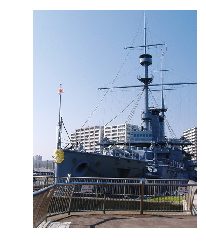

In [19]:
# visualize image
np.random.shuffle(val_images)
image = val_images[0]
im_RAW = cv2.imread(image.pathname)   
im_RAW = cv2.cvtColor(im_RAW, cv2.COLOR_BGR2RGB)
lp = image.rois["gt"]["labels"]
labels = lp_to_names(lp, dataset)
gt_classes = image.rois["gt"]["gt_classes"]
print("image.lp: ", lp)
print("image.labels: ", labels)
print("gt_classes: ", gt_classes)
plt.imshow(im_RAW)
_ = plt.axis("off")

In [20]:
cls_score, cls_prob, cls_pred = im_classify(sess, net, image, val_gen)

In [21]:
labels = lp_to_names(cls_pred[0],dataset)
keep = np.where(cls_pred[0] == 1)[-1]
probs = cls_prob[0][keep]
print("labels: ", labels)
print("probs: ", probs)

labels:  ['boat']
probs:  [0.60497284]


#### Evaluate val data

In [12]:
cls_probs = []
cls_preds = []
all_lp = []
all_labels = []
filenames = []
pathnames = []

for i, image in enumerate(val_images):
    if i%500 == 0:
        print("processed {}/{}".format(i, len(val_images)))
    
    #cls_score, cls_prob, cls_pred = im_classify(sess, net, image, val_gen)    
    #"""
    try:
        cls_score, cls_prob, cls_pred = im_classify(sess, net, image, val_gen)
    except:
        print("[ALERT] exception on ", image.filename)
        continue
    #"""
    filenames.append(image.filename)
    pathnames.append(image.pathname)
    lp = image.rois["gt"]["labels"]
    all_lp.append(lp)
    labels = lp_to_names(lp, dataset)
    all_labels.append(labels)    
    cls_probs.append(cls_prob[0])
    cls_preds.append(cls_pred[0])


processed 0/4952
[ALERT] exception on  000533.jpg
processed 500/4952
[ALERT] exception on  001744.jpg
processed 1000/4952
[ALERT] exception on  002018.jpg
processed 1500/4952
processed 2000/4952
[ALERT] exception on  004900.jpg
processed 2500/4952
[ALERT] exception on  005137.jpg
processed 3000/4952
[ALERT] exception on  006491.jpg
processed 3500/4952
processed 4000/4952
processed 4500/4952


In [13]:
data = {"filename": filenames, "pathname": pathnames, 
       "labels": all_labels, "lp": all_lp, "cls_pred": cls_preds, "cls_prob": cls_probs}
df_val_images = pd.DataFrame(data)

In [14]:
df_val_images.head()

,filename,pathname,labels,lp,cls_pred,cls_prob
0,000001.jpg,/home/rfm/eclipse/python/region-dh/data/voc_20...,"[dog, person]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.058378242, 0.058418717, 0.07242037, 0.04930..."
1,000002.jpg,/home/rfm/eclipse/python/region-dh/data/voc_20...,[train],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.058509976, 0.058309577, 0.07238316, 0.04915..."
2,000003.jpg,/home/rfm/eclipse/python/region-dh/data/voc_20...,"[chair, sofa]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.06035741, 0.060196538, 0.07445605, 0.050839..."
3,000004.jpg,/home/rfm/eclipse/python/region-dh/data/voc_20...,[car],"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.060373798, 0.06047984, 0.07517342, 0.051174..."
4,000006.jpg,/home/rfm/eclipse/python/region-dh/data/voc_20...,"[chair, diningtable, pottedplant]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.06306054, 0.06280941, 0.07706469, 0.0531831..."


In [15]:
with open("../data/voc_2007/20180804_df_val_images_ssdh.wl2.pkl",'wb') as fp:
    pickle.dump(df_val_images, fp)

In [16]:
cls_to_id = dataset.cls_to_id
id_to_cls = {v:k for (k,v) in cls_to_id.items()}

In [17]:
targets = np.array(list(df_val_images["lp"]))
targets = np.reshape(targets, [targets.shape[0], -1])
print(targets.shape)

(4946, 20)


In [18]:
preds = np.array(list(df_val_images["cls_pred"]))
preds = np.reshape(preds, [preds.shape[0], -1])
print(preds.shape)

(4946, 20)


In [19]:
from sklearn.metrics import precision_score, recall_score

In [20]:
evals = {}
mAP = 0

for id_cls in range(targets.shape[1]):
    prec = precision_score(targets[:, id_cls], preds[:, id_cls], average='weighted')
    rec = recall_score(targets[:, id_cls], preds[:, id_cls], average='weighted')
    
    if prec <= 0 or rec <= 0:
        f1_score = 0
    else:
        f1_score = 2*prec*prec/(prec+rec)
        
    evals[id_to_cls[id_cls+1]] = [f1_score]
    mAP += f1_score
    
mAP = mAP/targets.shape[1]
evals["mAP"] = [mAP]
    
df_evals= pd.DataFrame(evals)

/home/franck/.conda/envs/tensorflow_py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
# ssdh, wl.2
df_evals.head()

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,mAP
0,0.899378,0.87809,0.859872,0.913249,0.882796,0.90989,0.650714,0.840034,0.745596,0.936958,...,0.794905,0.864522,0.886571,0.680138,0.876681,0.952134,0.83044,0.873866,0.875742,0.851554


In [21]:
# wl.4
df_evals.head()

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,mAP
0,0.993052,0.983983,0.986421,0.989828,0.958817,0.983571,0.938369,0.983758,0.933821,0.988076,...,0.973615,0.982413,0.983188,0.871855,0.959349,0.990862,0.951772,0.98795,0.970583,0.969414


In [20]:
# wl.3
df_evals.head()

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,mAP
0,0.990101,0.985251,0.984076,0.98702,0.94918,0.983165,0.946772,0.98219,0.917613,0.977977,...,0.967671,0.981779,0.983974,0.90135,0.94048,0.988135,0.946476,0.989187,0.96784,0.967092


In [20]:
# wl.2
df_evals.head()

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,mAP
0,0.993052,0.984142,0.986477,0.990037,0.958702,0.983571,0.939336,0.983525,0.933763,0.987727,...,0.974554,0.982266,0.983205,0.872043,0.957893,0.990786,0.95163,0.98795,0.970391,0.969393


In [64]:
# wl.1
df_evals.head()

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,mAP
0,0.989883,0.9851,0.983481,0.986652,0.947858,0.982931,0.945889,0.981869,0.914532,0.977797,...,0.967398,0.982287,0.983795,0.901293,0.942819,0.987618,0.945761,0.988716,0.966327,0.966652


In [22]:
#evals

In [22]:
#df_evals.to_csv("../data/voc_2007/20180804_df_evals_ssdh.wl2.csv")